In [0]:
# fastai 0.7.0
!mkdir src -p && cd src && git clone https://github.com/fastai/fastai.git
!pip3 install -U pillow==4.1.1
!pip3 install -q bcolz graphviz sklearn_pandas isoweek pandas_summary ipywidgets torch torchvision torchtext pillow

Cloning into 'fastai'...
remote: Enumerating objects: 20555, done.
remote: Total 20555 (delta 0), reused 0 (delta 0), pack-reused 20555
Receiving objects: 100% (20555/20555), 350.45 MiB | 29.80 MiB/s, done.
Resolving deltas: 100% (14183/14183), done.
Checking out files: 100% (746/746), done.
    100% |████████████████████████████████| 5.7MB 7.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
tcmalloc: large alloc 1073750016 bytes == 0x62130000 @  0x7f518d2272a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# fastai 0.7.0
import sys
sys.path.append("/content/src/fastai/old") # on windows use \'s instead

from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

print(torch.__version__)
torch.backends.cudnn.benchmark=True
torch.cuda.is_available(), torch.backends.cudnn.enabled

1.0.0


(True, True)

## Pascal VOC 2007

In [0]:
PATH = Path('data')
os.makedirs(PATH, exist_ok=True)

In [0]:
!cd {PATH} && curl --header "Host: host.robots.ox.ac.uk" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.62 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header "Accept-Language: zh,zh-CN;q=0.9,zh-TW;q=0.8,en-US;q=0.7,en;q=0.6" --header "Referer: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html" "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar" -o "VOCtrainval_11-May-2012.tar" -L
!cd {PATH} && tar xf VOCtrainval_11-May-2012.tar
!find {PATH} -type d

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1907M  100 1907M    0     0  78.8M      0  0:00:24  0:00:24 --:--:-- 84.6M
data
data/VOCdevkit
data/VOCdevkit/VOC2012
data/VOCdevkit/VOC2012/ImageSets
data/VOCdevkit/VOC2012/ImageSets/Layout
data/VOCdevkit/VOC2012/ImageSets/Segmentation
data/VOCdevkit/VOC2012/ImageSets/Main
data/VOCdevkit/VOC2012/ImageSets/Action
data/VOCdevkit/VOC2012/JPEGImages
data/VOCdevkit/VOC2012/SegmentationObject
data/VOCdevkit/VOC2012/SegmentationClass
data/VOCdevkit/VOC2012/Annotations


In [0]:
!ls {PATH}/VOCdevkit/VOC2007/JPEGImages | head -5

ls: cannot access 'data/VOCdevkit/VOC2007/JPEGImages': No such file or directory


In [0]:
!ls {PATH}/VOCdevkit/VOC2007/Annotations | head -5

ls: cannot access 'data/VOCdevkit/VOC2007/Annotations': No such file or directory


In [0]:
!cd {PATH} && wget -q https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
!cd {PATH} && unzip -q PASCAL_VOC.zip
list((PATH/'PASCAL_VOC/').iterdir())

[PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json')]

In [0]:
JPEG_PATH = 'VOCdevkit/VOC2012/JPEGImages'
IMG_PATH = PATH/JPEG_PATH
METADATA_PATH = PATH/'PASCAL_VOC'

In [0]:
trn_json = json.load((METADATA_PATH/'pascal_train2012.json').open())
val_json = json.load((METADATA_PATH/'pascal_val2012.json').open())
trn_json.keys(), val_json.keys()

(dict_keys(['images', 'type', 'annotations', 'categories']),
 dict_keys(['images', 'type', 'annotations', 'categories']))

## EDA

In [0]:
i = 0

print("images:")
display(val_json['images'][i])
print("\nannotations:")
display(val_json['annotations'][i])
print("\ncategories:")
display(val_json['categories'][i])
print("\ntype:")
display(val_json['type'][i])

images:


{'file_name': '2008_000002.jpg', 'height': 375, 'id': 2008000002, 'width': 500}


annotations:


{'area': 117445,
 'bbox': [33, 10, 415, 283],
 'category_id': 20,
 'id': 1,
 'ignore': 0,
 'image_id': 2008000002,
 'iscrowd': 0,
 'segmentation': [[33, 10, 33, 293, 448, 293, 448, 10]]}


categories:


{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'}


type:


'i'

In [0]:
display(val_json['annotations'][:5])

[{'area': 117445,
  'bbox': [33, 10, 415, 283],
  'category_id': 20,
  'id': 1,
  'ignore': 0,
  'image_id': 2008000002,
  'iscrowd': 0,
  'segmentation': [[33, 10, 33, 293, 448, 293, 448, 10]]},
 {'area': 146965,
  'bbox': [45, 10, 455, 323],
  'category_id': 19,
  'id': 2,
  'ignore': 0,
  'image_id': 2008000003,
  'iscrowd': 0,
  'segmentation': [[45, 10, 45, 333, 500, 333, 500, 10]]},
 {'area': 1188,
  'bbox': [61, 189, 22, 54],
  'category_id': 15,
  'id': 3,
  'ignore': 0,
  'image_id': 2008000003,
  'iscrowd': 0,
  'segmentation': [[61, 189, 61, 243, 83, 243, 83, 189]]},
 {'area': 27392,
  'bbox': [0, 229, 428, 64],
  'category_id': 4,
  'id': 4,
  'ignore': 0,
  'image_id': 2008000007,
  'iscrowd': 0,
  'segmentation': [[0, 229, 0, 293, 428, 293, 428, 229]]},
 {'area': 4758,
  'bbox': [216, 160, 78, 61],
  'category_id': 10,
  'id': 5,
  'ignore': 0,
  'image_id': 2008000009,
  'iscrowd': 0,
  'segmentation': [[216, 160, 216, 221, 294, 221, 294, 160]]}]

In [0]:
i2clas = {o['id']:o['name'] for o in val_json['categories']}
i2fn = {o['id']:o['file_name'] for o in val_json['images']}
fnames = [o['file_name'] for o in val_json['images']]

In [0]:
annos = collections.defaultdict(lambda: [])
for o in val_json['annotations']:
  if o['ignore'] == 0:
    annos[i2fn[o['image_id']]].append((o['bbox'], o['category_id']))
annos

defaultdict(<function __main__.<lambda>>,
            {'2008_000002.jpg': [([33, 10, 415, 283], 20)],
             '2008_000003.jpg': [([45, 10, 455, 323], 19),
              ([61, 189, 22, 54], 15)],
             '2008_000007.jpg': [([0, 229, 428, 64], 4)],
             '2008_000009.jpg': [([216, 160, 78, 61], 10),
              ([464, 166, 36, 52], 10)],
             '2008_000016.jpg': [([90, 14, 302, 339], 20)],
             '2008_000021.jpg': [([13, 147, 462, 141], 1)],
             '2008_000026.jpg': [([121, 6, 251, 369], 15),
              ([210, 146, 115, 109], 12)],
             '2008_000027.jpg': [([8, 31, 492, 344], 7)],
             '2008_000032.jpg': [([5, 117, 484, 157], 6),
              ([335, 172, 29, 52], 15)],
             '2008_000034.jpg': [([5, 233, 40, 129], 5),
              ([0, 155, 103, 181], 15),
              ([35, 110, 163, 306], 15),
              ([90, 41, 248, 459], 15)],
             '2008_000042.jpg': [([444, 253, 56, 82], 7)],
             '2008_00004

In [0]:
def show_img(ax, fpath):
  im = open_image(IMG_PATH/fnames[i])
  ax.imshow(im)
  ax.axis('off')

'bbox: [([5, 233, 40, 129], 5), ([0, 155, 103, 181], 15), ([35, 110, 163, 306], 15), ([90, 41, 248, 459], 15)]'

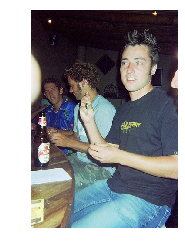

In [0]:
i = 9
fpath = IMG_PATH/fnames[i]
display('bbox: ' + str(annos[fnames[i]]))
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)

In [0]:
def draw_outline(patch, lw):
  patch.set_path_effects([ patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal() ])
  
def draw_bbox(ax, bbox, color='white'):
  patch = ax.add_patch(patches.Rectangle(bbox[:2], *bbox[2:], fill=False, edgecolor=color, lw=2))
  draw_outline(patch, 2)
  
def draw_txt(ax, xy, txt, sz=14):
  text = ax.text(*xy, txt, fontsize=sz, color='white', weight='bold', verticalalignment='top')
  draw_outline(text, 1)

def show_bbox(ax, bb):
  for b, c in bb:
    draw_bbox(ax, b, )
    draw_txt(ax, b[:2], i2clas[c])

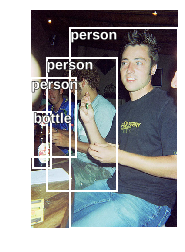

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)
show_bbox(ax, annos[fnames[i]])

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
  color_norm = mcolors.Normalize(0, N - 1)
  return cmx.ScalarMappable(color_norm, 'Set3').to_rgba

def show_bbox(ax, bb):
  for i, (b, c) in enumerate(bb):
    draw_bbox(ax, b, color=colors[i % NUM_COLORS])
    draw_txt(ax, b[:2], i2clas[c])
    
NUM_COLORS = 12
cmap = get_cmap(NUM_COLORS)
colors = [cmap(float(i)) for i in range(NUM_COLORS)]

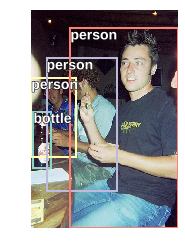

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, fpath)
show_bbox(ax, annos[fnames[i]])

## Prepare Data

In [0]:
len(trn_json['images']), len(val_json['images'])

(5717, 5823)

In [0]:
def get_annos(ds):
  annos = collections.defaultdict(lambda: [])
  i2fn = {o['id']:o['file_name'] for o in ds['images']}
  i2clas = {o['id']:o['name'] for o in val_json['categories']}
  for o in ds['annotations']:
    if not o['ignore']:
      annos[i2fn[o['image_id']]].append((np.array(o['bbox']), i2clas[o['category_id']]))
  return annos

trn_annos = get_annos(trn_json)
val_annos = get_annos(val_json)
len(trn_annos), len(val_annos)

(5717, 5823)

In [0]:
# (y, x, y`, x`) -> (x, y, width, height) 
def from_bb(bb): return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])
# (x, y, width, height) -> (y, x, y`, x`)
def to_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])

train_annos = {}
for k, v in trn_annos.items():
  train_annos[k] = v
for k, v in val_annos.items():
  train_annos[k] = v

fnames = []
bboxes = []
claz = []
val_idxs = []

for k, v in train_annos.items():
  fnames.append(k)
  bb, clas = [], []
  for b, c in v:
    bb.append(to_bb(b))
    clas.append(c)
  bboxes.append(' '.join([str(o) for o in np.concatenate(bb)]))
  claz.append(' '.join([str(o) for o in clas]))

train_df = pd.DataFrame({'fname': fnames, 'bounding box': bboxes, 'categories': claz},
                           columns=['fname', 'bounding box', 'categories'])
train_df.to_csv(PATH/'train_bbox.csv', index=False)
display(train_df.head())

# val_idxs
val_fnames = np.array([k for k, _ in val_annos.items()])
for i, o in enumerate(train_df.fname.values):
  if o in val_fnames: val_idxs.append(i)
val_idxs = np.array(val_idxs)
pickle.dump(val_idxs, open(PATH/'val_idxs.pkl', 'wb'))
val_idxs

fname                                       bounding box  \
0  2008_000008.jpg                       86 52 419 470 43 157 166 288   
1  2008_000015.jpg                         0 269 175 377 0 56 149 163   
2  2008_000019.jpg         1 138 196 371 65 164 235 317 0 360 111 479   
3  2008_000023.jpg  0 5 261 313 96 39 410 120 35 136 108 168 35 17...   
4  2008_000028.jpg                      198 157 239 230 201 46 237 93   

                              categories  
0                           horse person  
1                          bottle bottle  
2                            dog dog dog  
3  tvmonitor bottle person person person  
4                                car car

array([ 5717,  5718,  5719, ..., 11537, 11538, 11539])

In [0]:
train_df = pd.read_csv(PATH/'train_bbox.csv')
val_idxs = pickle.load(open(PATH/'val_idxs.pkl', 'rb'))
labels = np.unique(np.concatenate([o.split(' ') for o in train_df.categories.values]))
ltoi = {o:i for i, o in enumerate(labels)}
labels, len(labels)

(array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
       dtype='<U11'), 20)

## The Largest Object

### Prepare Data

In [0]:
def get_lrg_anno(anno):
  return sorted(anno, key=lambda x: x[0][2] * x[0][3], reverse=True)[0]

train_lrg_annos = {k:get_lrg_anno(v) for k, v in train_annos.items()}
pickle.dump(train_lrg_annos, open(PATH/'train_lrg_annos.pkl', 'wb'))

In [0]:
def show_lrg_bbox(ax, anno):
  draw_bbox(ax, anno[0], color=colors[i % NUM_COLORS])
  draw_txt(ax, anno[0][:2], anno[1])

def show_bbox(ax, bb):
  for i, (b, c) in enumerate(bb):
    draw_bbox(ax, b, color=colors[i % NUM_COLORS])
    draw_txt(ax, b[:2], c)

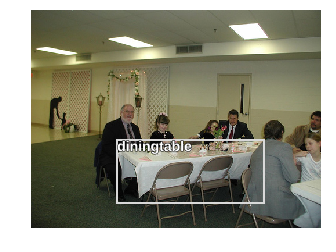

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_lrg_bbox(ax, train_lrg_annos[fnames[i]])

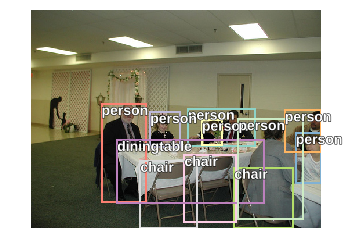

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_bbox(ax, train_annos[fnames[i]])

In [0]:
# (y, x, y`, x`) -> (x, y, width, height) 
def from_bb(bb): return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# (x, y, width, height) -> (y, x, y`, x`)
def to_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])

In [0]:
fnames = []
bboxes = []
claz = []

for k, (b, c) in train_lrg_annos.items():
  fnames.append(k)
  bboxes.append(' '.join([str(o) for o in to_bb(b)]))
  claz.append(c)

train_lrg_bb_df = pd.DataFrame({'fname': fnames, 'bounding box': bboxes}, columns=['fname', 'bounding box'])
display(train_lrg_bb_df.head())
train_lrg_bb_df.to_csv(PATH/'train_lrg_bbox.csv', index=False)

train_lrg_clas_df = pd.DataFrame({'fname': fnames, 'class': claz}, columns=['fname', 'class'])
display(train_lrg_clas_df.head())
train_lrg_clas_df.to_csv(PATH/'train_lrg_clas.csv', index=False)

val_idxs = get_cv_idxs(len(train_lrg_bb_df))
pickle.dump(val_idxs, open(PATH/'val_idxs.pkl', 'wb'))

fname     bounding box
0  2008_000008.jpg    86 52 419 470
1  2008_000015.jpg    0 269 175 377
2  2008_000019.jpg    1 138 196 371
3  2008_000023.jpg      0 5 261 313
4  2008_000028.jpg  198 157 239 230

fname      class
0  2008_000008.jpg      horse
1  2008_000015.jpg     bottle
2  2008_000019.jpg        dog
3  2008_000023.jpg  tvmonitor
4  2008_000028.jpg        car

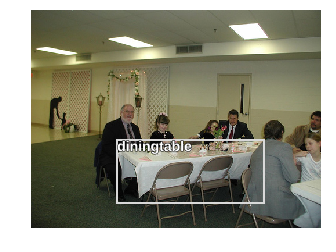

In [0]:
i = 8
fig, ax = plt.subplots(figsize=(6, 4))
show_img(ax, IMG_PATH/fnames[i])
show_lrg_bbox(ax, (from_bb(np.array(train_lrg_bb_df.loc[i, 'bounding box'].split(' ')).astype(int)),
                   train_lrg_clas_df.loc[i, 'class']))

### Image Recognition

In [0]:
arch = resnet34
sz = 224
bs = 64
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_clas.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
md.c, np.array(md.classes)

(20,
 array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
       dtype='<U11'))

In [0]:
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 82511441.24it/s]


 80%|████████  | 116/145 [01:18<00:17,  1.68it/s, loss=5.43]

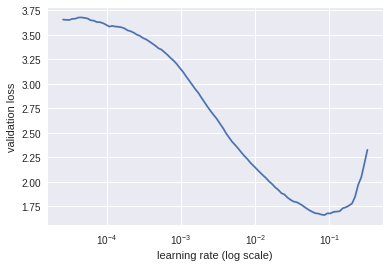

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=2, use_clr=(10, 10))
learn.save('lrg_img_fz')

epoch      trn_loss   val_loss   accuracy   
    0      0.807189   0.615285   0.812825  
    1      0.599568   0.535633   0.840555  


In [0]:
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.fit(lrs / 10, 1, cycle_len=2, use_clr=(20, 10))
learn.save('lrg_img')

epoch      trn_loss   val_loss   accuracy   
    0      0.601184   0.528094   0.836655  
    1      0.334767   0.498876   0.847487  


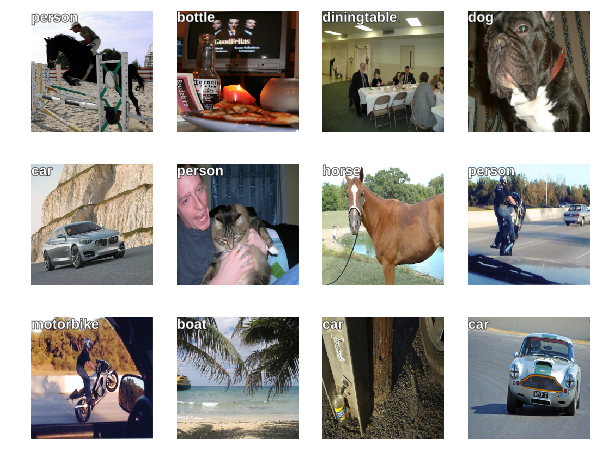

In [0]:
learn.load('lrg_img')
x, y = next(iter(learn.data.val_dl))
yp = predict_batch(learn.model, x)
x = learn.data.val_ds.denorm(x)
yl = labels[yp.max(1)[1].data.cpu().numpy()]

fig, axes = plt.subplots(3, 4, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  draw_txt(ax, (0, 0), yl[i])
  ax.axis('off')

### Bounding Box

In [0]:
arch = resnet34
sz = 224
bs = 64
aug_tfms = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(5, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_bbox.csv', bs=bs, tfms=tfms, val_idxs=val_idxs, continuous=True)
md.c

4

In [0]:
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam
learn.crit = F.l1_loss

 98%|█████████▊| 142/145 [02:10<00:01,  2.12it/s, loss=280]

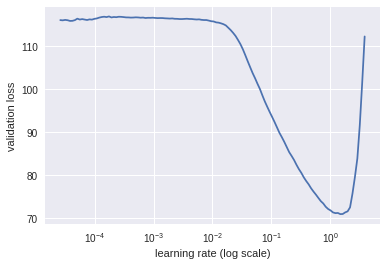

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-1
learn.fit(lr, 1, cycle_len=3, use_clr=(10, 10))
learn.save('lrg_bbox_fz')

epoch      trn_loss   val_loss   
    0      31.633369  27.029304 
    1      28.608124  26.231282 
    2      27.359085  27.458307 


 91%|█████████ | 132/145 [02:16<00:12,  1.03it/s, loss=88.2]

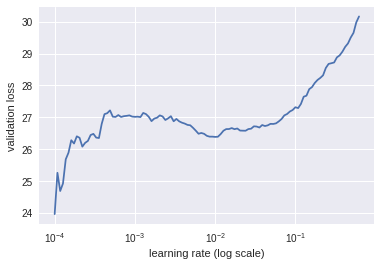

In [0]:
learn.load('lrg_bbox_fz')
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.lr_find(lrs / 1000)
learn.sched.plot(0, 20)

In [0]:
learn.fit(lrs / 20, 1, cycle_len=4, use_clr=(10, 10))
learn.save('lrg_bbox')

epoch      trn_loss   val_loss   
    0      24.534589  23.231544 
    1      21.299118  46.510004 
    2      19.73664   17.859919 
    3      18.409843  16.747539 


### Object Detection： image recognition + bounding box

In [0]:
arch = resnet34
sz = 224
bs = 64
aug_tfms = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(5, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
clas_md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_clas.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_lrg_bbox.csv', bs=bs, tfms=tfms, val_idxs=val_idxs,
                                       continuous=True)
c = md.c + clas_md.c

In [0]:
class ObjectDataset(Dataset):
  def __init__(self, ds, y): self.ds, self.y = ds, y
  def __getitem__(self, i):
    xi, yi = self.ds[i]
    return (xi, (yi, self.y[i]))
  @property
  def c(self): return c
  @property
  def is_multi(self): return False
  @property
  def is_reg(self): return True
  @property
  def sz(self): return sz

In [0]:
md.trn_dl.dataset = ObjectDataset(md.trn_ds, clas_md.trn_y)
md.val_dl.dataset = ObjectDataset(md.val_ds, clas_md.val_y)

In [0]:
x, y = next(iter(md.val_dl))
y[0].shape, y[1].shape

(torch.Size([64, 4]), torch.Size([64]))

In [0]:
nin = 7 * 7 * 512
nf = 512
ps = np.array([0.25, 0.5])

def custom_head():
  return nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(ps[0]),
    nn.Linear(nin, nf),
    nn.ReLU(),
    nn.Dropout(ps[1]),
    nn.Linear(nf, c)
)

custom_head_f = custom_head()

In [0]:
learn = ConvLearner.pretrained(arch, md, custom_head=custom_head_f)
learn.opt_fn = optim.Adam

In [0]:
def object_loss(preds, targs):
  bb_t, clas_t = targs
  bb_p = preds[:, :4]
  bb_p = F.sigmoid(bb_p) * sz
  clas_p = preds[:, 4:]
  return F.l1_loss(bb_p, bb_t) + F.cross_entropy(clas_p, clas_t) * 20

def clas_metric(preds, targs): return accuracy(preds[:, 4:], targs[1])

def bb_metric(preds, targs):
  bb_p = preds[:, :4]
  bb_p = F.sigmoid(bb_p) * sz
  return F.l1_loss(bb_p, targs[0])

In [0]:
learn.crit = object_loss
learn.metrics = [clas_metric, bb_metric]

  1%|          | 1/145 [00:07<17:26,  7.27s/it, loss=145]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      164.258711 127.261626 0.043328   37.005031 


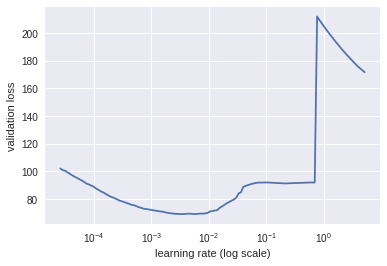

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=2, use_clr=(10, 10))
learn.save('fz')

  1%|          | 1/145 [00:06<16:05,  6.70s/it, loss=146]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      53.240019  39.675418  0.79896    25.424594 
    1      44.515194  36.6847    0.816724   24.277196 


  0%|          | 0/145 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      90.974263  143.348848 0.036828   38.102482 


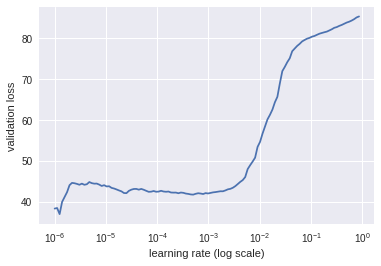

In [0]:
learn.unfreeze()
lrs = np.array([lr / 100, lr / 10, lr])
learn.lr_find(lrs / 1000)
learn.sched.plot(0, 20)

In [0]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10))
learn.save('lrg_od')

  0%|          | 0/145 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch      trn_loss   val_loss   clas_metric bb_metric  
    0      48.056418  37.632276  0.807192   24.481316 
    1      37.165874  34.25995   0.832322   22.201957 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


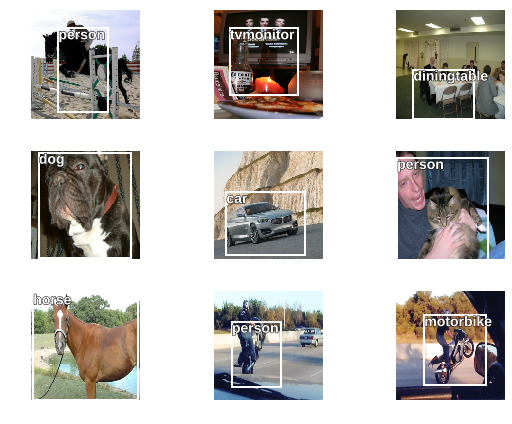

In [0]:
x, y = next(iter(md.val_dl))
yp = predict_batch(learn.model, x)
bb_p, clas_p = yp[:, :4], yp[:, 4:]
bb = F.sigmoid(bb_p) * sz
clas = torch.max(F.log_softmax(clas_p), dim=1)[1]
x = md.val_ds.ds.denorm(x)

fig, axes = plt.subplots(3, 3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  xywh = from_bb(bb[i])
  draw_bbox(ax, xywh)
  draw_txt(ax, xywh[:2], clas_md.classes[clas[i]])
  ax.axis('off')
plt.tight_layout()

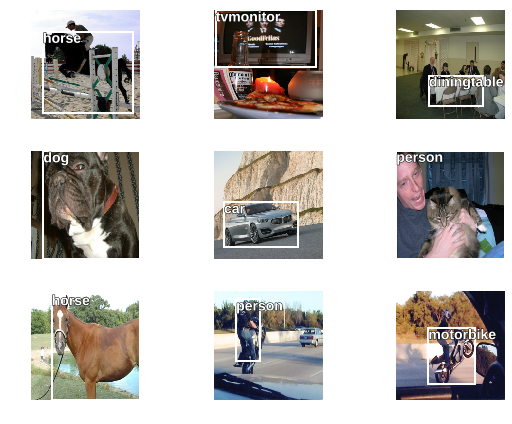

In [0]:
x, y = next(iter(md.val_dl))
x = md.val_ds.ds.denorm(x)
bb, clas = y

fig, axes = plt.subplots(3, 3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(x[i])
  xywh = from_bb(bb[i])
  draw_bbox(ax, xywh)
  draw_txt(ax, xywh[:2], clas_md.classes[clas[i]])
  ax.axis('off')
plt.tight_layout()

## SSD

### Classification

In [0]:
train_df = pd.read_csv(PATH/'train_bbox.csv')
cols = ['fname', 'categories']
train_clas_df = train_df[cols].copy()
train_clas_df.to_csv(PATH/'train_clas.csv', index=False)
train_clas_df.head()

fname                             categories
0  2008_000008.jpg                           horse person
1  2008_000015.jpg                          bottle bottle
2  2008_000019.jpg                            dog dog dog
3  2008_000023.jpg  tvmonitor bottle person person person
4  2008_000028.jpg                                car car

In [0]:
arch = resnet34
sz = 224
bs = 64
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO)
val_idxs = pickle.load(open(PATH/'val_idxs.pkl', 'rb'))
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_clas.csv', bs=bs, tfms=tfms, val_idxs=val_idxs)
md.c, np.array(md.classes)

(20,
 array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
       dtype='<U11'))

In [0]:
learn = ConvLearner.pretrained(arch, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 92172642.34it/s]


epoch      trn_loss   val_loss   <lambda>   
    0      1.059341   5.087902   0.815585  



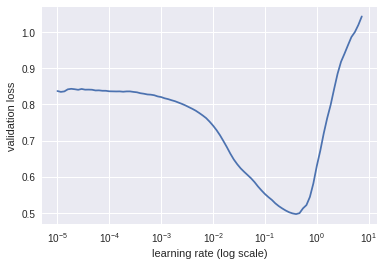

In [0]:
learn.lr_find()
learn.sched.plot(0, 0)

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=5, use_clr=(20, 5))
learn.save('clas')

epoch      trn_loss   val_loss   <lambda>   
    0      0.209789   0.082015   0.971578  
    1      0.105096   0.07692    0.973321  
    2      0.081515   0.075133   0.974068  
    3      0.070129   0.073762   0.974352  
    4      0.060756   0.073015   0.974515  



In [0]:
x,y = next(iter(md.val_dl))
yp = predict_batch(learn.model, x)
ima = md.val_ds.denorm(x)

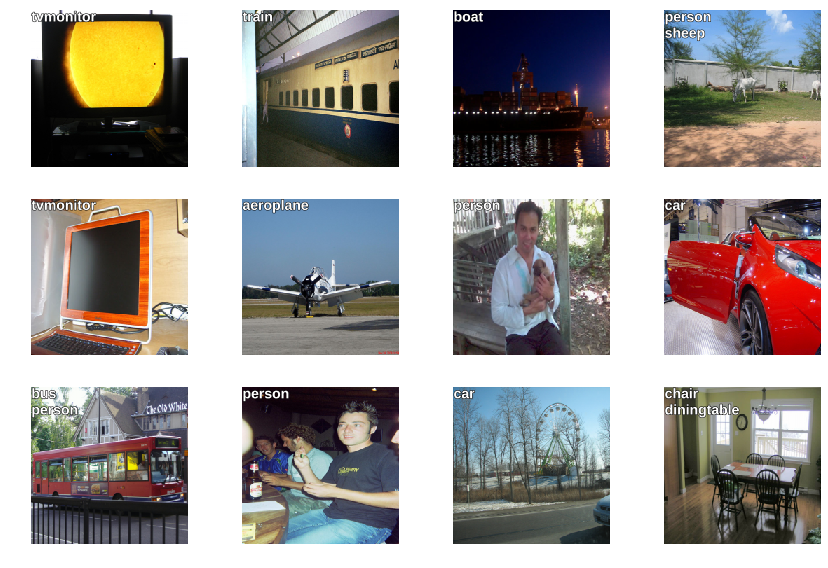

In [0]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ya = np.nonzero(yp[i]>0.4)[:, 0]
    b = '\n'.join(md.classes[o] for o in to_np(ya))
    ax.imshow(ima[i])
    draw_txt(ax, (0,0), b)
    ax.axis('off')
plt.tight_layout()

### Groud Truth

In [0]:
train_df = pd.read_csv(PATH/'train_bbox.csv')
claz = np.array([np.array([ltoi[p] for p in o.split(' ')]) for o in train_df.categories.values])
claz

array([array([12, 14]), array([4, 4]), array([11, 11, 11]), ..., array([6]), array([4]), array([0])],
      dtype=object)

In [0]:
arch = resnet34
sz = 224
bs = 64
aug_tfms = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)
]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y=TfmType.COORD)
val_idxs = pickle.load(open(PATH/'val_idxs.pkl', 'rb'))
md = ImageClassifierData.from_csv(PATH, JPEG_PATH, PATH/'train_bbox.csv', bs=bs, tfms=tfms,
                                  val_idxs=val_idxs, continuous=True, num_workers=10)

In [0]:
class ObjectDataset(Dataset):
  def __init__(self, ds, y):
    self.ds = ds
    self.y = y
  def __getitem__(self, i):
    xi, yi = self.ds[i]
    return (xi, (yi, self.y[i]))
  @property
  def c(self): return c
  @property
  def is_multi(self): return False
  @property
  def is_reg(self): return True
  @property
  def sz(self): return sz

((val_y, trn_y),) = split_by_idx(val_idxs, claz)
md.trn_dl.dataset = ObjectDataset(md.trn_ds, trn_y)
md.val_dl.dataset = ObjectDataset(md.val_ds, val_y)
len(val_y), len(trn_y)

(5823, 5717)

In [0]:
x, y = next(iter(md.val_dl))
ima = md.val_ds.ds.denorm(x)

In [0]:
i = 9
bb = y[0][i].view(-1, 4)
clas = y[1][i]
bb, clas, bb.shape, clas.shape

(tensor([[  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.],
         [105.,   4., 161.,  28.],
         [ 70.,   0., 149.,  66.],
         [ 50.,  24., 185., 129.],
         [ 19.,  60., 223., 222.]], device='cuda:0'),
 tensor([ 0,  0,  0,  4, 14, 14, 14], device='cuda:0'),
 torch.Size([7, 4]),
 torch.Size([7]))

In [0]:
def draw_gt(ax, box, clas=None, prob=None, num_classes=0, thresh=0.5):
  if clas is None: clas = [None] * box.shape[0]
  if prob is None: prob = [None] * box.shape[0]
  for i, (b, c, p) in enumerate(zip(box, clas, prob)):
    if b[2] > 0 and (p is None or p >= thresh):
      txt = f'{i}:'
      txt += ' bg' if c is None or c >= num_classes else labels[c]
      txt += '' if p is None else f' {p:.2f}'
      draw_bbox(ax, from_bb(b), color=colors[i % NUM_COLORS])
      draw_txt(ax, (b[1], b[0]), txt)

(-0.5, 223.5, 223.5, -0.5)

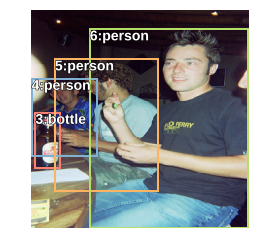

In [0]:
i = 9
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(ima[i])
draw_gt(ax, y[0][i].view(-1, 4), y[1][i], num_classes=len(labels))
ax.axis('off')

### SSD Network Part 1

In [0]:
nf = 256
num_classes = len(labels)

def conv_layer(nin, nf, stride=2, drop=0.1):
  return nn.Sequential(
      nn.Conv2d(nin, nf, 3, stride, 1, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(nf),
      nn.Dropout(drop)
  )

class Outlayer(nn.Module):
  def __init__(self, nf, num_classes, bias):
    super().__init__()
    self.clas_conv = nn.Conv2d(nf, num_classes + 1, 3, 1, 1)
    self.bb_conv = nn.Conv2d(nf, 4, 3, 1, 1)
    self.clas_conv.bias.data.zero_().add_(bias)
    
  def flatten(self, x):
    bs, nf, w, h = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf)
  
  def forward(self, x):
    return [self.flatten(self.bb_conv(x)), self.flatten(self.clas_conv(x))]

class SSDHead(nn.Module):
  def __init__(self, num_classes, nf, bias, drop_i=0.25):
    super().__init__()
    self.conv1 = conv_layer(512, nf, stride=1)
    self.conv2 = conv_layer(nf, nf)
    self.drop_i = nn.Dropout(drop_i)
    self.out = Outlayer(nf, num_classes, bias=bias)
  
  def forward(self, x):
    x = self.drop_i(F.relu(x))
    x = self.conv1(x)
    x = self.conv2(x)
    return self.out(x)
  
ssd_head_f = SSDHead(num_classes, nf, bias=-3.)

In [0]:
learn = ConvLearner.pretrained(arch, md, custom_head=ssd_head_f)
learn.opt_fn = optim.Adam

In [0]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

### Default Box

In [0]:
cells = 4
width = 1 / cells
cx = np.repeat(np.linspace(width / 2, 1 - (width / 2), cells), cells)
cy = np.tile(np.linspace(width / 2, 1 - (width / 2), cells), cells)
w = h = np.array([width] * cells**2)
def_box = T(np.stack([cx, cy, w, h], 1))
def_box

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

(0, 1)

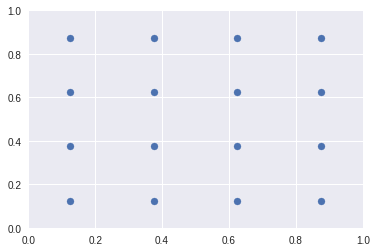

In [0]:
plt.scatter(def_box.cpu()[:, 0], def_box.cpu()[:, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)

In [0]:
# (cx, cy, w, h) -> (x, y, x`, y`)
def def_box_to_bb(cxy, wh): return torch.cat([cxy - wh/2, cxy + wh/2], 1)
# (x, y, x`, y`) -> (x, y, w, h)
def def_box_from_bb(xy, xy2): return torch.cat([xy, xy2 - xy], 1)

In [0]:
def_box_bb = def_box_to_bb(def_box[:, :2], def_box[:, 2:])
def_box_bb

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0')

(-0.5, 223.5, 223.5, -0.5)

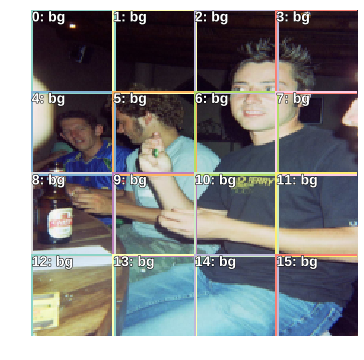

In [0]:
i = 9
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ima[i])
draw_gt(ax, def_box_bb * sz)
# draw_gt(ax, y[0][i].view(-1, 4), y[1][i])
ax.axis('off')

### Jaccard Index

In [0]:
def box_size(box): return (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])

def intersection(gt, def_box):
  left_top = torch.max(gt[:, None, :2], def_box[None, :, :2])
  right_bottom = torch.min(gt[:, None, 2:], def_box[None, :, 2:])
  wh = torch.clamp(right_bottom - left_top, min=0)
  return wh[:, :, 0] * wh[:, :, 1]
  
def jaccard(gt, def_box):
  inter = intersection(gt, def_box)
  union = box_size(gt).unsqueeze(1) + box_size(def_box).unsqueeze(0) - inter
  return inter / union

In [0]:
bb, clas = y[0][i].view(-1, 4), y[1][i]
idxs = np.nonzero(bb[:, 2] > 0)[:, 0]
bb, clas = bb[idxs], clas[idxs]
bb, clas

(tensor([[105.,   4., 161.,  28.],
         [ 70.,   0., 149.,  66.],
         [ 50.,  24., 185., 129.],
         [ 19.,  60., 223., 222.]], device='cuda:0'),
 tensor([ 4, 14, 14, 14], device='cuda:0'))

In [0]:
overlap = jaccard(bb, def_box_bb * sz)
overlap

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0390, 0.0000, 0.0000, 0.0000, 0.3559,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3921, 0.0530, 0.0000, 0.0000, 0.3300,
         0.0464, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0112, 0.0198, 0.0059, 0.0000, 0.1155, 0.2212, 0.0582, 0.0000, 0.1155,
         0.2212, 0.0582, 0.0000, 0.0324, 0.0582, 0.0170, 0.0000],
        [0.0000, 0.0562, 0.0607, 0.0584, 0.0000, 0.0875, 0.0949, 0.0912, 0.0000,
         0.0875, 0.0949, 0.0912, 0.0000, 0.0858, 0.0930, 0.0894]],
       device='cuda:0')

In [0]:
gt_best_overlap, gt_db_idx = overlap.max(1)
gt_best_overlap, gt_db_idx

(tensor([0.3559, 0.3921, 0.2212, 0.0949], device='cuda:0'),
 tensor([ 8,  4,  9, 10], device='cuda:0'))

In [0]:
db_best_overlap, db_gt_idx = overlap.max(0)
db_best_overlap, db_gt_idx

(tensor([0.0112, 0.0562, 0.0607, 0.0584, 0.3921, 0.2212, 0.0949, 0.0912, 0.3559,
         0.2212, 0.0949, 0.0912, 0.0324, 0.0858, 0.0930, 0.0894],
        device='cuda:0'),
 tensor([2, 3, 3, 3, 1, 2, 3, 3, 0, 2, 3, 3, 2, 3, 3, 3], device='cuda:0'))

In [0]:
db_best_overlap[gt_db_idx] = 1.1
db_best_overlap

tensor([0.0112, 0.0562, 0.0607, 0.0584, 1.1000, 0.2212, 0.0949, 0.0912, 1.1000,
        1.1000, 1.1000, 0.0912, 0.0324, 0.0858, 0.0930, 0.0894],
       device='cuda:0')

In [0]:
is_obj = db_best_overlap > 0.5
pos_idxs = np.nonzero(is_obj)[:, 0]
neg_idxs = np.nonzero(1 - is_obj)[:, 0]
pos_idxs, neg_idxs

(tensor([ 4,  8,  9, 10], device='cuda:0'),
 tensor([ 0,  1,  2,  3,  5,  6,  7, 11, 12, 13, 14, 15], device='cuda:0'))

In [0]:
db_clas = T([num_classes] * len(db_best_overlap))
db_clas[pos_idxs] = clas[db_gt_idx[pos_idxs]]
db_clas

tensor([20, 20, 20, 20, 14, 20, 20, 20,  4, 14, 14, 20, 20, 20, 20, 20],
       device='cuda:0')

(-0.5, 223.5, 223.5, -0.5)

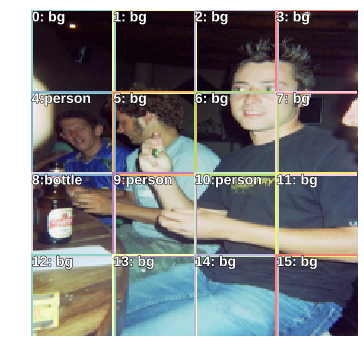

In [0]:
i = 9
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ima[i])
draw_gt(ax, def_box_bb * sz, db_clas, num_classes=num_classes)
ax.axis('off')

### More Default Boxes

In [0]:
cells = np.array([4, 2, 1])
center_offsets = 1 / cells / 2
aspect_ratios = [(1., 1.), (1., .5), (.5, 1.)]
zooms = [0.7, 1., 1.3]
scales = [(o * i, o * j) for o in zooms for i, j in aspect_ratios]
k = len(scales)
k, scales

(9,
 [(0.7, 0.7),
  (0.7, 0.35),
  (0.35, 0.7),
  (1.0, 1.0),
  (1.0, 0.5),
  (0.5, 1.0),
  (1.3, 1.3),
  (1.3, 0.65),
  (0.65, 1.3)])

In [0]:
def_box = []
for off, c in zip(center_offsets, cells):
  cx = np.repeat(np.repeat(np.linspace(off, 1 - off, c), c), k)
  cy = np.repeat(np.tile(np.linspace(off, 1 - off, c), c), k)
  w =  np.tile([off * 2 * o for o, _ in scales], c**2)
  h =  np.tile([off * 2 * o for _, o in scales], c**2)
  def_box.append(np.stack([cx, cy, w, h], 1))
def_box = T(np.concatenate(def_box))
def_box

tensor([[0.1250, 0.1250, 0.1750, 0.1750],
        [0.1250, 0.1250, 0.1750, 0.0875],
        [0.1250, 0.1250, 0.0875, 0.1750],
        [0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.2500, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.2500],
        [0.1250, 0.1250, 0.3250, 0.3250],
        [0.1250, 0.1250, 0.3250, 0.1625],
        [0.1250, 0.1250, 0.1625, 0.3250],
        [0.1250, 0.3750, 0.1750, 0.1750],
        [0.1250, 0.3750, 0.1750, 0.0875],
        [0.1250, 0.3750, 0.0875, 0.1750],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.1250],
        [0.1250, 0.3750, 0.1250, 0.2500],
        [0.1250, 0.3750, 0.3250, 0.3250],
        [0.1250, 0.3750, 0.3250, 0.1625],
        [0.1250, 0.3750, 0.1625, 0.3250],
        [0.1250, 0.6250, 0.1750, 0.1750],
        [0.1250, 0.6250, 0.1750, 0.0875],
        [0.1250, 0.6250, 0.0875, 0.1750],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.1250],
        [0.1250, 0.6250, 0.1250, 0

In [0]:
def_box_bb = def_box_to_bb(def_box[:, :2], def_box[:, 2:])
def_box_bb

tensor([[ 0.0375,  0.0375,  0.2125,  0.2125],
        [ 0.0375,  0.0812,  0.2125,  0.1688],
        [ 0.0812,  0.0375,  0.1688,  0.2125],
        [ 0.0000,  0.0000,  0.2500,  0.2500],
        [ 0.0000,  0.0625,  0.2500,  0.1875],
        [ 0.0625,  0.0000,  0.1875,  0.2500],
        [-0.0375, -0.0375,  0.2875,  0.2875],
        [-0.0375,  0.0438,  0.2875,  0.2062],
        [ 0.0438, -0.0375,  0.2062,  0.2875],
        [ 0.0375,  0.2875,  0.2125,  0.4625],
        [ 0.0375,  0.3313,  0.2125,  0.4187],
        [ 0.0812,  0.2875,  0.1688,  0.4625],
        [ 0.0000,  0.2500,  0.2500,  0.5000],
        [ 0.0000,  0.3125,  0.2500,  0.4375],
        [ 0.0625,  0.2500,  0.1875,  0.5000],
        [-0.0375,  0.2125,  0.2875,  0.5375],
        [-0.0375,  0.2937,  0.2875,  0.4563],
        [ 0.0438,  0.2125,  0.2062,  0.5375],
        [ 0.0375,  0.5375,  0.2125,  0.7125],
        [ 0.0375,  0.5813,  0.2125,  0.6687],
        [ 0.0812,  0.5375,  0.1688,  0.7125],
        [ 0.0000,  0.5000,  0.2500

In [0]:
grid_size = T(np.concatenate([[1./c] * c**2 * k for c in cells])[:, None])
grid_size

tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0

In [0]:
overlap = jaccard(bb, def_box_bb * sz)
gt_best_overlap, gt_db_idx = overlap.max(1)
db_best_overlap, db_gt_idx = overlap.max(0)
db_best_overlap[gt_db_idx] = 1.1
is_obj = db_best_overlap > 0.5
pos_idxs = np.nonzero(is_obj)[:, 0]
neg_idxs = np.nonzero(1 - is_obj)[:, 0]
db_clas = T([num_classes] * len(db_best_overlap))
db_clas[pos_idxs] = clas[db_gt_idx[pos_idxs]]
db_best_overlap, db_clas

(tensor([0.0000, 0.0000, 0.0000, 0.0112, 0.0069, 0.0000, 0.0308, 0.0194, 0.0034,
         0.0335, 0.0169, 0.0223, 0.0562, 0.0309, 0.0358, 0.0770, 0.0485, 0.0482,
         0.0335, 0.0169, 0.0223, 0.0607, 0.0309, 0.0386, 0.0943, 0.0485, 0.0587,
         0.0335, 0.0169, 0.0223, 0.0584, 0.0309, 0.0372, 0.0798, 0.0485, 0.0499,
         0.2424, 0.1237, 0.1474, 0.3921, 0.2098, 0.3007, 1.1000, 0.3043, 0.3581,
         0.1084, 0.0542, 0.0542, 0.2212, 0.1106, 0.1106, 0.3572, 0.1797, 0.1869,
         0.0465, 0.0232, 0.0232, 0.0949, 0.0474, 0.0474, 0.1604, 0.0802, 0.0802,
         0.0465, 0.0232, 0.0232, 0.0912, 0.0474, 0.0457, 0.1344, 0.0802, 0.0680,
         1.1000, 0.2223, 0.2223, 0.3559, 0.3082, 0.3000, 0.3852, 0.3426, 0.2866,
         0.1084, 0.0542, 0.0542, 0.2212, 0.1106, 0.1106, 0.3739, 0.1869, 0.1869,
         0.0465, 0.0232, 0.0232, 0.0949, 0.0474, 0.0474, 0.1604, 0.0802, 0.0802,
         0.0465, 0.0232, 0.0232, 0.0912, 0.0474, 0.0457, 0.1344, 0.0802, 0.0680,
         0.0131, 0.0080, 0.0

(-0.5, 223.5, 223.5, -0.5)

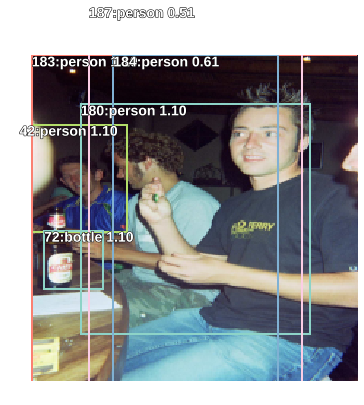

In [0]:
i = 9
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ima[i])
draw_gt(ax, def_box_bb * sz, db_clas, prob=db_best_overlap, num_classes=num_classes)
ax.axis('off')

### Train 4x4

In [0]:
cells = 4
width = 1 / cells
cx = np.repeat(np.linspace(width / 2, 1 - (width / 2), cells), cells)
cy = np.tile(np.linspace(width / 2, 1 - (width / 2), cells), cells)
w = h = np.array([width] * cells**2)
def_box = V(np.stack([cx, cy, w, h], 1))
def_box_bb = def_box_to_bb(def_box[:, :2], def_box[:, 2:])
grid_size = T([width] * cells**2)
def_box, def_box_bb, grid_size

(tensor([[0.1250, 0.1250, 0.2500, 0.2500],
         [0.1250, 0.3750, 0.2500, 0.2500],
         [0.1250, 0.6250, 0.2500, 0.2500],
         [0.1250, 0.8750, 0.2500, 0.2500],
         [0.3750, 0.1250, 0.2500, 0.2500],
         [0.3750, 0.3750, 0.2500, 0.2500],
         [0.3750, 0.6250, 0.2500, 0.2500],
         [0.3750, 0.8750, 0.2500, 0.2500],
         [0.6250, 0.1250, 0.2500, 0.2500],
         [0.6250, 0.3750, 0.2500, 0.2500],
         [0.6250, 0.6250, 0.2500, 0.2500],
         [0.6250, 0.8750, 0.2500, 0.2500],
         [0.8750, 0.1250, 0.2500, 0.2500],
         [0.8750, 0.3750, 0.2500, 0.2500],
         [0.8750, 0.6250, 0.2500, 0.2500],
         [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.2500, 0.2500],
         [0.0000, 0.2500, 0.2500, 0.5000],
         [0.0000, 0.5000, 0.2500, 0.7500],
         [0.0000, 0.7500, 0.2500, 1.0000],
         [0.2500, 0.0000, 0.5000, 0.2500],
         [0.2500, 0.2500, 0.5000, 0.5000],
         [0.2500, 0.5000, 0.5000, 0

In [0]:
class BCELoss(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    
  def get_weight(self, x, t): return None
  
  def forward(self, x, t):
    x = x[:, :-1]
    one_hot_t = torch.eye(num_classes + 1)[t.data.cpu()]
    t = V(one_hot_t[:, :-1].contiguous())
    w = self.get_weight(x, t)
    return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

bce_loss_f = BCELoss(num_classes)

In [0]:
def loc_loss(preds, targs):
  return (preds - targs).abs().mean()

def conf_loss(preds, targs):
  return bce_loss_f(preds, targs)
  
def offset_to_bb(off, db_bb):
    off = F.tanh(off)
    center = (off[:, :2] / 2) * db_bb[:, 2:] + db_bb[:, :2]
    wh = ((off[:, 2:] / 2) + 1) * db_bb[:, 2:]
    return def_box_to_bb(center, wh)

def _ssd_loss(db_offset, clas, bb_gt, clas_gt):
  bb = offset_to_bb(db_offset, def_box)
  bb_gt = bb_gt.view(-1, 4) / sz
  idxs = np.nonzero(bb_gt[:, 2] > 0)[:, 0]
  bb_gt, clas_gt = bb_gt[idxs], clas_gt[idxs]
  overlap = jaccard(bb_gt, def_box_bb)
  gt_best_overlap, gt_db_idx = overlap.max(1)
  db_best_overlap, db_gt_idx = overlap.max(0)
  db_best_overlap[gt_db_idx] = 1.1
  for i, o in enumerate(gt_db_idx): db_gt_idx[o] = i
  is_obj = db_best_overlap >= 0.5
  pos_idxs = np.nonzero(is_obj)[:, 0]
  neg_idxs = np.nonzero(1 - is_obj.data)[:, 0]
  db_clas = clas_gt[db_gt_idx]
  db_clas[neg_idxs] = len(labels)
  db_bb = bb_gt[db_gt_idx]
  return (loc_loss(bb[pos_idxs], db_bb[pos_idxs]), bce_loss_f(clas, db_clas))

def ssd_loss(preds, targs, print_loss=False):
#   alpha = 1.
  loc_loss, conf_loss = 0., 0.
  for i, (db_offset, clas, bb_gt, clas_gt) in enumerate(zip(*preds, *targs)):
    losses = _ssd_loss(db_offset, clas, bb_gt, clas_gt)
    loc_loss += losses[0]# * alpha
    conf_loss += losses[1]
  if print_loss:
    print(f'loc loss: {loc_loss:.2f}, conf loss: {conf_loss:.2f}')
  return loc_loss + conf_loss

In [0]:
x, y = next(iter(md.trn_dl))
x, y = V(x), V(y)
yp = predict_batch(learn.model, x)
ssd_loss(yp, y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(81.6845, device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
learn = ConvLearner.pretrained(arch, md, custom_head=ssd_head_f)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 77%|███████▋  | 69/90 [02:02<00:10,  2.09it/s, loss=200]

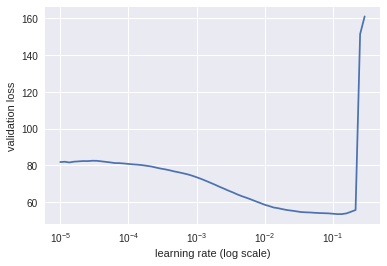

In [0]:
learn.lr_find()
learn.sched.plot(0, 0)

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=8, use_clr=(20, 5))
learn.save('16')

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch      trn_loss   val_loss   
    0      33.574218  34.117771 
    1      30.093091  29.408577 
    2      27.206728  27.568285 
    3      25.348878  26.957813 
    4      23.976828  26.765239 
    5      22.80882   26.695604 
    6      21.532631  26.688388 
    7      20.018111  26.610572 


In [0]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
b_bb, b_clas = learn.model(x)

(-0.5, 223.5, 223.5, -0.5)

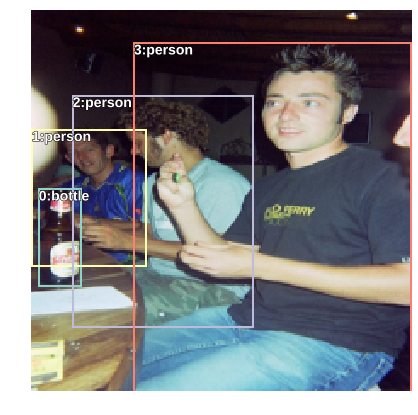

In [0]:
idx=9
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bb_gt = y[0][idx].view(-1, 4) / sz
idxs = np.nonzero(bb_gt[:, 2] > 0)[:, 0]
bb_gt, clas_gt = bb_gt[idxs], y[1][idx][idxs]
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(ima)
draw_gt(ax, bb_gt.data * sz, clas_gt.data, num_classes=num_classes)
ax.axis('off')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(-0.5, 223.5, 223.5, -0.5)

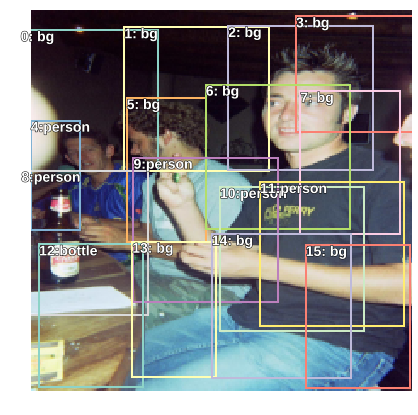

In [0]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(ima)
bb = offset_to_bb(b_bboxi, def_box)
draw_gt(ax, bb * sz, b_clasi.data.max(1)[1], num_classes=num_classes)
ax.axis('off')

### SSD Network Part 2

In [0]:
cells = np.array([4, 2, 1])
center_offsets = 1 / cells / 2
aspect_ratios = [(1., 1.), (1., .5), (.5, 1.)]
zooms = [0.7, 1., 1.3]
scales = [(o * i, o * j) for o in zooms for i, j in aspect_ratios]
k = len(scales)

def_box = []
for off, c in zip(center_offsets, cells):
  cx = np.repeat(np.repeat(np.linspace(off, 1 - off, c), c), k)
  cy = np.repeat(np.tile(np.linspace(off, 1 - off, c), c), k)
  w =  np.tile([off * 2 * o for o, _ in scales], c**2)
  h =  np.tile([off * 2 * o for _, o in scales], c**2)
  def_box.append(np.stack([cx, cy, w, h], 1))
def_box = T(np.concatenate(def_box))
def_box_bb = def_box_to_bb(def_box[:, :2], def_box[:, 2:])

grid_size = T(np.concatenate([[1./c] * c**2 * k for c in cells])[:, None])

k, scales, def_box, def_box_bb, grid_size

(9,
 [(0.7, 0.7),
  (0.7, 0.35),
  (0.35, 0.7),
  (1.0, 1.0),
  (1.0, 0.5),
  (0.5, 1.0),
  (1.3, 1.3),
  (1.3, 0.65),
  (0.65, 1.3)],
 tensor([[0.1250, 0.1250, 0.1750, 0.1750],
         [0.1250, 0.1250, 0.1750, 0.0875],
         [0.1250, 0.1250, 0.0875, 0.1750],
         [0.1250, 0.1250, 0.2500, 0.2500],
         [0.1250, 0.1250, 0.2500, 0.1250],
         [0.1250, 0.1250, 0.1250, 0.2500],
         [0.1250, 0.1250, 0.3250, 0.3250],
         [0.1250, 0.1250, 0.3250, 0.1625],
         [0.1250, 0.1250, 0.1625, 0.3250],
         [0.1250, 0.3750, 0.1750, 0.1750],
         [0.1250, 0.3750, 0.1750, 0.0875],
         [0.1250, 0.3750, 0.0875, 0.1750],
         [0.1250, 0.3750, 0.2500, 0.2500],
         [0.1250, 0.3750, 0.2500, 0.1250],
         [0.1250, 0.3750, 0.1250, 0.2500],
         [0.1250, 0.3750, 0.3250, 0.3250],
         [0.1250, 0.3750, 0.3250, 0.1625],
         [0.1250, 0.3750, 0.1625, 0.3250],
         [0.1250, 0.6250, 0.1750, 0.1750],
         [0.1250, 0.6250, 0.1750, 0.0875],
     

In [0]:
nf = 256
num_classes = len(labels)

def conv_layer(nin, nf, stride=2, drop=0.1):
  return nn.Sequential(
      nn.Conv2d(nin, nf, 3, stride, 1, bias=False),
      nn.ReLU(),
      nn.BatchNorm2d(nf),
      nn.Dropout(drop)
  )

class Outlayer(nn.Module):
  def __init__(self, nf, num_classes, bias):
    super().__init__()
    self.clas_conv = nn.Conv2d(nf, (num_classes + 1) * k, 3, 1, 1)
    self.bb_conv = nn.Conv2d(nf, 4 * k, 3, 1, 1)
    self.clas_conv.bias.data.zero_().add_(bias)
  
  def flatten(self, x):
    bs, nf, w, h = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf // k)
  
  def forward(self, x):
    return [self.flatten(self.bb_conv(x)), self.flatten(self.clas_conv(x))]

class SSDHead(nn.Module):
  def __init__(self, num_classes, nf, bias, drop_i=0.25, drop_h=0.1):
    super().__init__()
    self.conv1 = conv_layer(512, nf, stride=1, drop=drop_h)
    self.conv2 = conv_layer(nf, nf, drop=drop_h)   # 4x4
    self.conv3 = conv_layer(nf, nf, drop=drop_h)   # 2x2
    self.conv4 = conv_layer(nf, nf, drop=drop_h)   # 1x1
    self.drop_i = nn.Dropout(drop_i)
    self.out1 = Outlayer(nf, num_classes, bias)
    self.out2 = Outlayer(nf, num_classes, bias)
    self.out3 = Outlayer(nf, num_classes, bias)
  
  def forward(self, x):
    x = self.drop_i(F.relu(x))
    x = self.conv1(x)
    x = self.conv2(x)
    bb1, clas1 = self.out1(x)
    x = self.conv3(x)
    bb2, clas2 = self.out2(x)
    x = self.conv4(x)
    bb3, clas3 = self.out3(x)
    return [torch.cat([bb1, bb2, bb3], 1),
            torch.cat([clas1, clas2, clas3], 1)]

drops = [0.4, 0.2]
ssd_head_f = SSDHead(num_classes, nf, -4., drop_i=drops[0], drop_h=drops[1])

In [0]:
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=ssd_head_f)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [0]:
x, y = next(iter(md.trn_dl))
yp = predict_batch(learn.model, x)
ssd_loss(yp, y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(287.4339, device='cuda:0', grad_fn=<AddBackward0>)

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 80%|████████  | 72/90 [02:03<00:09,  1.95it/s, loss=553]

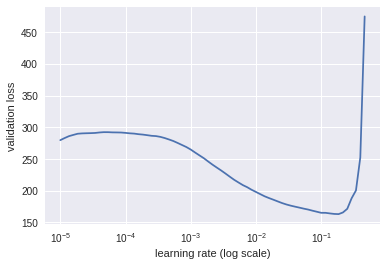

In [0]:
learn.lr_find()
learn.sched.plot(0, 0)

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20, 10))
learn.save('multi')

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch      trn_loss   val_loss   
    0      87.026507  75.858966 
    1      68.657919  62.675859 
    2      58.815842  78.257847 
    3      53.675965  54.85459  
    4      49.656684  53.707109 
    5      46.777794  53.003534 
    6      44.20865   51.358076 
    7      41.394307  51.515281 
    8      38.741202  50.559135 
    9      36.69472   50.12559  


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(-0.5, 223.5, 223.5, -0.5)

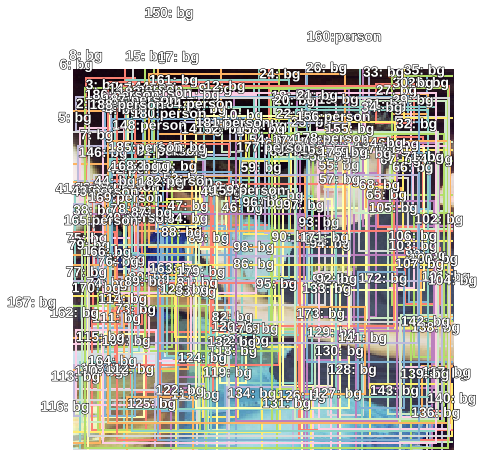

In [0]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
b_bb, b_clas = learn.model(x)

idx=9
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md.val_ds.ds.denorm(to_np(x))[idx]
bb = offset_to_bb(b_bboxi, def_box)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(ima)
draw_gt(ax, bb * sz, b_clasi.data.max(1)[1], num_classes=num_classes)
ax.axis('off')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(-0.5, 223.5, 223.5, -0.5)

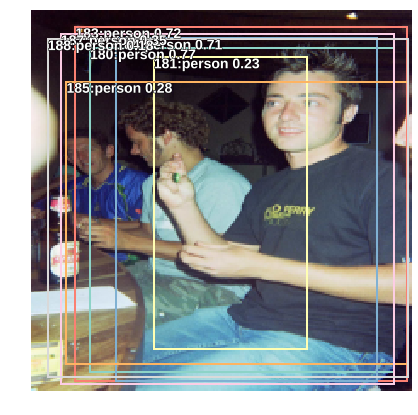

In [0]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(ima)
draw_gt(ax, bb * sz, b_clasi.data.max(1)[1], num_classes=num_classes, prob=F.sigmoid(b_clasi).max(1)[0], thresh=0.15)
ax.axis('off')

### NMS

In [0]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [0]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_bb, b_clas = batch
x = to_np(x)

In [0]:
def show_nmf(idx, thresh=0.15):
    ima=md.val_ds.ds.denorm(x)[idx]
    bb_gt = y[0][idx].view(-1, 4) / sz
    idxs = np.nonzero(bb_gt[:, 2] > 0)[:, 0]
    bb_gt, clas_gt = bb_gt[idxs], y[1][idx][idxs]
    bb = offset_to_bb(b_bb[idx], def_box)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > thresh
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(bb)
        boxes = bb[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(ima)
    draw_gt(ax, out2 * sz, cc, num_classes=num_classes, prob=out1, thresh=0.1)
    ax.axis('off')
#     torch_gt(ax, ima, out2, cc, out1, 0.1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0: empty array


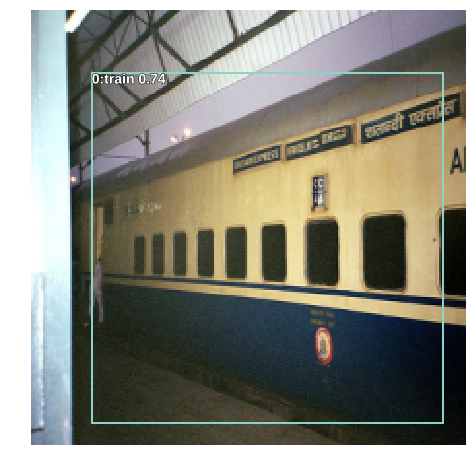

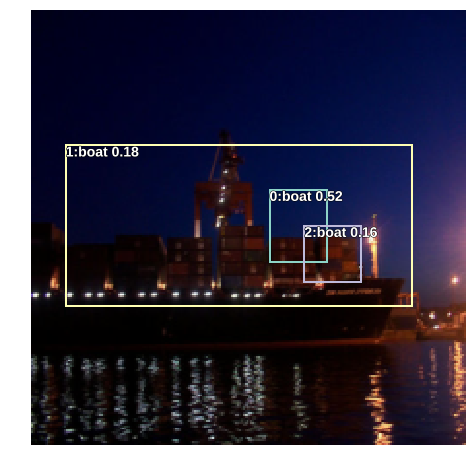

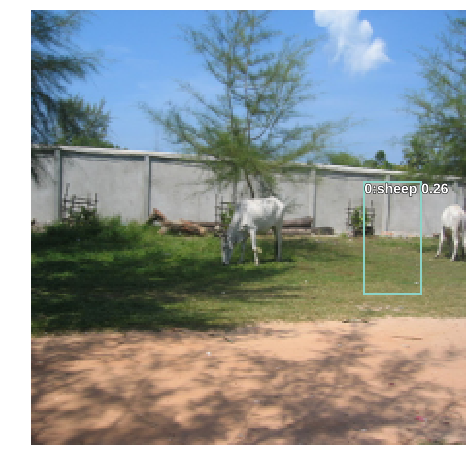

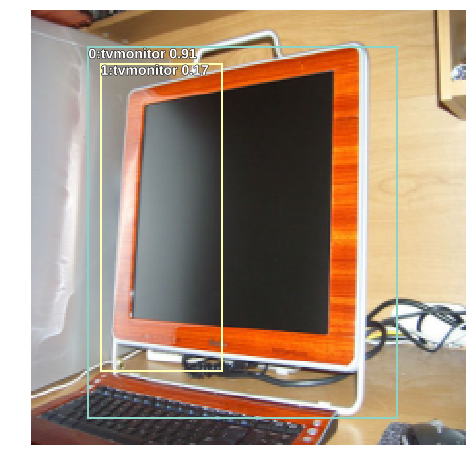

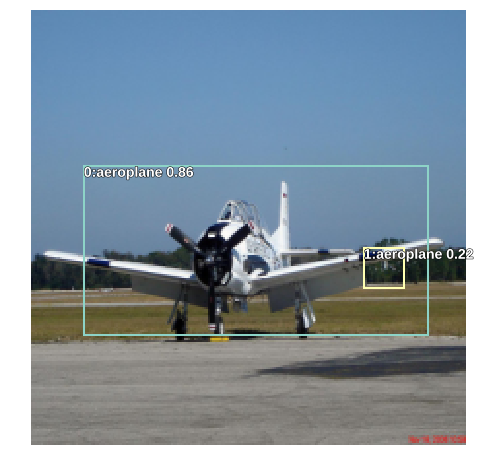

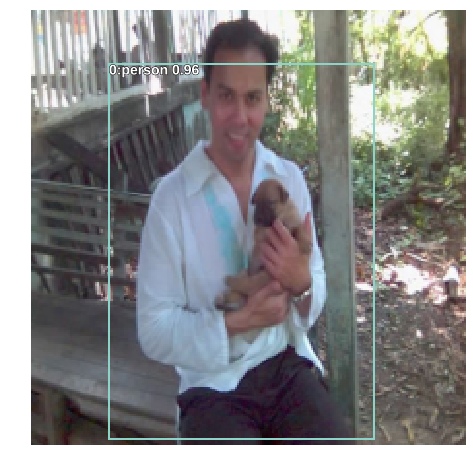

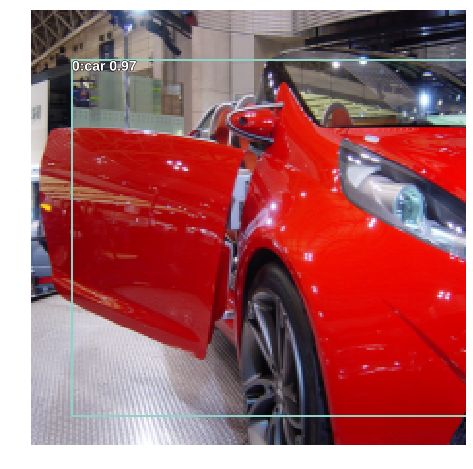

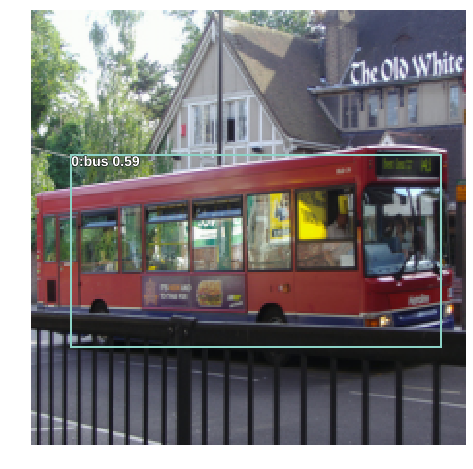

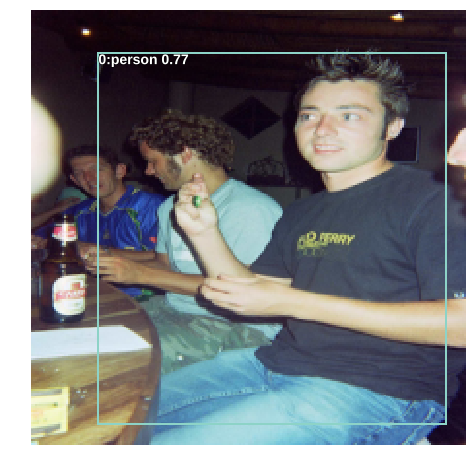

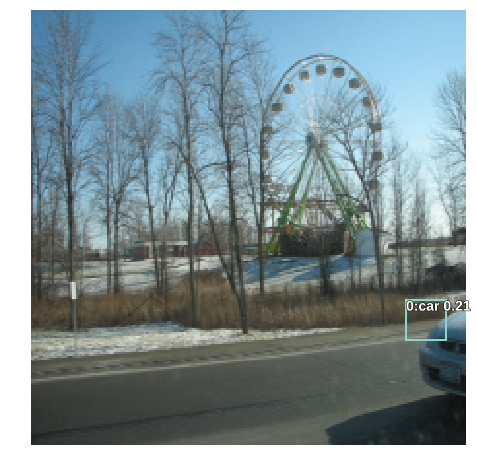

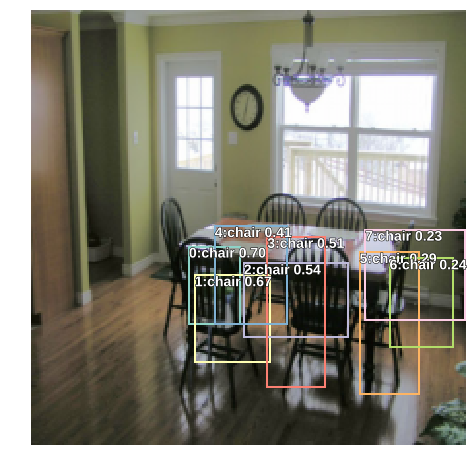

In [0]:
for i in range(12): show_nmf(i)

In [0]:
x, y = next(iter(md.trn_dl))
yp = predict_batch(learn.model, x)
ssd_loss(yp, y, True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loc loss: 3.65, conf loss: 28.08


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(31.7384, device='cuda:0', grad_fn=<AddBackward0>)

### Focal Loss

In [0]:
class FocalLoss(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes
    
  def get_weight(self, x, t):
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
  
  def forward(self, x, t):
    x = x[:, :-1]
    one_hot_t = torch.eye(num_classes + 1)[t.data.cpu()]
    t = V(one_hot_t[:, :-1].contiguous())
    w = self.get_weight(V(x), V(t))
    return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes

bce_loss_f = FocalLoss(num_classes)

In [0]:
x, y = next(iter(md.trn_dl))
x, y = V(x), V(y)
yp = predict_batch(learn.model, x)
ssd_loss(yp, y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(10.5473, device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
drops = [0.4, 0.3]
ssd_head_f = SSDHead(num_classes, nf, -4., drop_i=drops[0], drop_h=drops[1])
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=ssd_head_f)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 73%|███████▎  | 66/90 [02:04<00:13,  1.84it/s, loss=76.2]

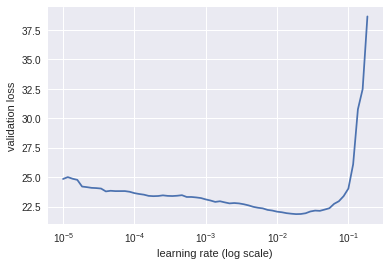

In [0]:
learn.lr_find()
learn.sched.plot(0, 0)

In [0]:
lr = 1e-2
learn.fit(lr, 1, cycle_len=10, use_clr=(20, 10))
learn.save('focal_loss')

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch      trn_loss   val_loss   
    0      17.30767   18.866698 
    1      15.211579  13.772004 
    2      13.563804  13.015255 
    3      12.589626  12.785115 
    4      11.926406  12.28807  
    5      11.515744  11.814605 
    6      11.109133  11.686357 
    7      10.664063  11.424233 
    8      10.285392  11.338397 
    9      9.935587   11.185435 


In [0]:
drops = [0.4, 0.4]
ssd_head_f = SSDHead(num_classes, nf, -4., drop_i=drops[0], drop_h=drops[1])
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=ssd_head_f)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss
learn.load('focal_loss')

In [0]:
learn.freeze_to(-2)
learn.fit(lr/4, 1, cycle_len=10, use_clr=(20, 10))
learn.save('focal_loss-2')

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch      trn_loss   val_loss   
    0      12.697291  13.894148 
    1      12.30151   12.959271 
    2      11.377315  12.223762 
    3      10.876366  11.95752  
    4      10.325061  11.09771  
    5      9.747867   11.102276 
    6      9.317195   10.934855 
    7      8.848167   10.552236 
    8      8.577048   10.396601 
    9      8.15503    10.254623 


In [0]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_bb, b_clas = batch
x = to_np(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


3: empty array
10: empty array


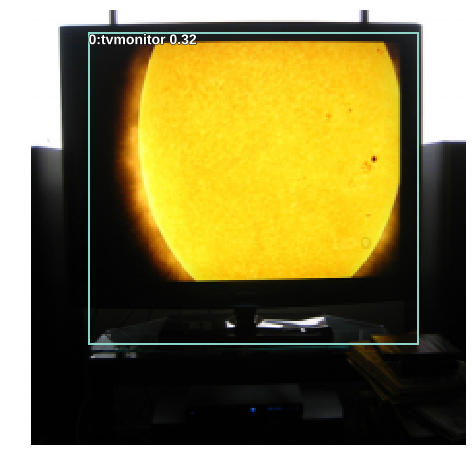

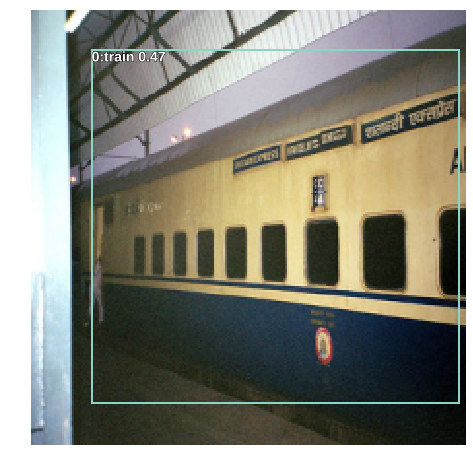

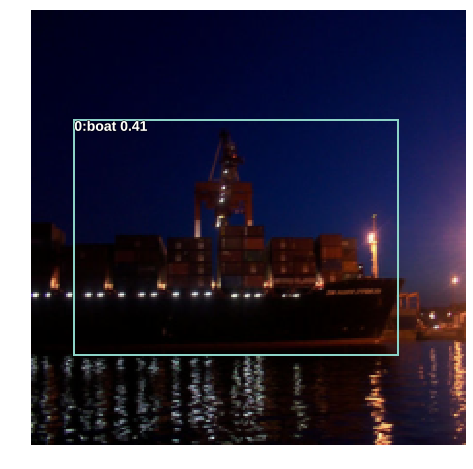

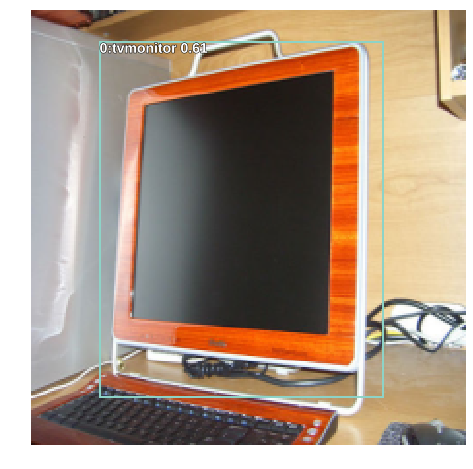

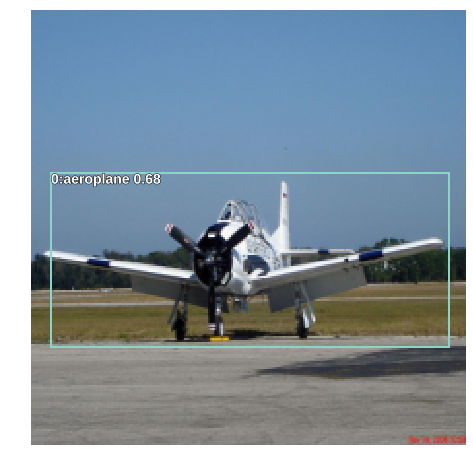

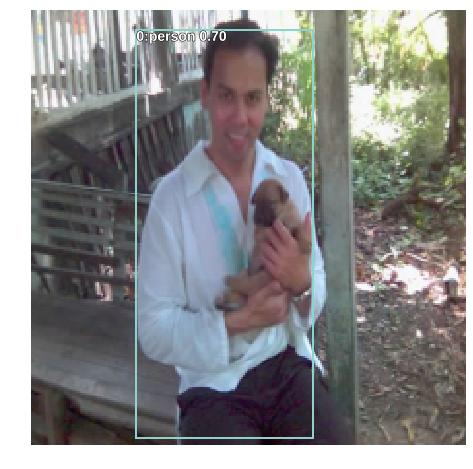

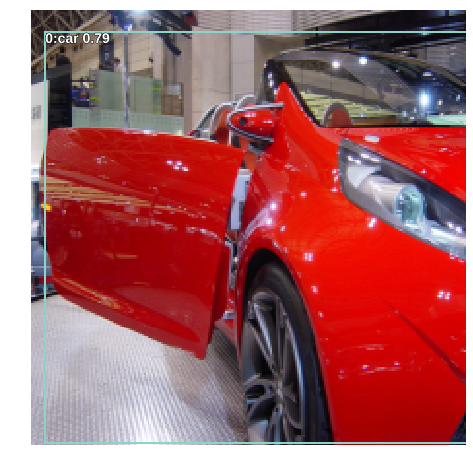

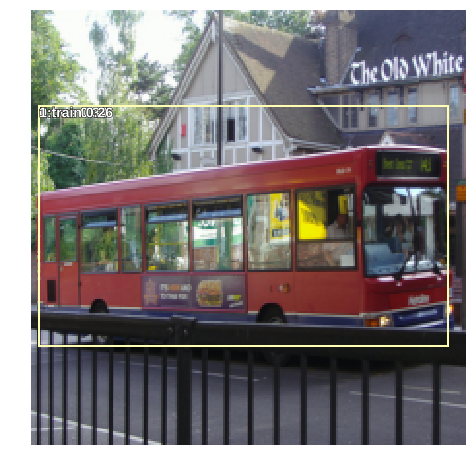

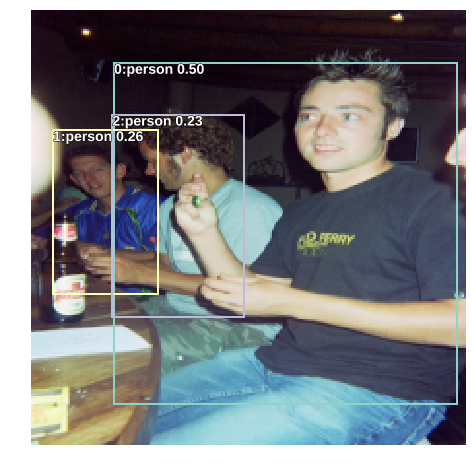

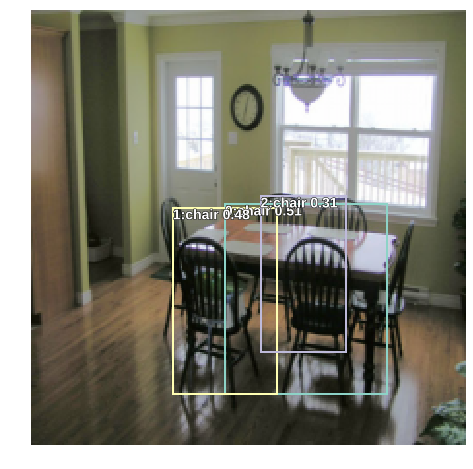

In [0]:
for i in range(12): show_nmf(i, thresh=0.2)

## END